In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [ ]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/MyDrive/potato1/train1/LeafRoll',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/MyDrive/potato1/test1/LeafRoll ',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:10<00:00, 18.76it/s]


In [ ]:
print(len(lrv_test))

200


In [ ]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
virus_train_label = np.full(len(virus_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
healthy_train_label = np.full(len(healthy_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
virus_test_label = np.full(len(virus_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
healthy_test_label = np.full(len(healthy_test),6)

In [ ]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, virus_train, insect_train, lrv_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, virus_train_label, insect_train_label, lrv_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, virus_test, insect_test, lrv_test,  healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, virus_test_label, insect_test_label, lrv_test_label, healthy_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

vgg19      = VGG19(include_top=False, input_shape=input_shape)(inputs)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(vgg19)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 concatenate (Concatenate)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                              

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/Vgg19(7_classes)_old.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
137/136 [==============================] - ETA: 0s - loss: 2.3437 - accuracy: 0.2030

136/136 [==============================] - 143s 847ms/step - loss: 2.3437 - accuracy: 0.2030 - val_loss: 7.5260 - val_accuracy: 0.1363 - lr: 1.0000e-04
Epoch 2/50
137/136 [==============================] - ETA: 0s - loss: 1.9217 - accuracy: 0.2959

136/136 [==============================] - 103s 751ms/step - loss: 1.9217 - accuracy: 0.2959 - val_loss: 2.9300 - val_accuracy: 0.2187 - lr: 1.0000e-04
Epoch 3/50
137/136 [==============================] - ETA: 0s - loss: 1.6276 - accuracy: 0.3513

136/136 [==============================] - 106s 776ms/step - loss: 1.6276 - accuracy: 0.3513 - val_loss: 1.4852 - val_accuracy: 0.3074 - lr: 1.0000e-04
Epoch 4/50
137/136 [==============================] - ETA: 0s - loss: 1.6609 - accuracy: 0.3357

136/136 [==============================] - 99s 725ms/step - loss: 1.6609 - accuracy: 0.3357 - val_loss: 4.9034 - val_accuracy: 0.1757 - lr: 1.0000e-04
Epoch 5/50
137/136 [==============================] - ETA: 0s - loss: 1.7573 - accuracy: 0.3192

136/136 [==============================] - 106s 775ms/step - loss: 1.7573 - accuracy: 0.3192 - val_loss: 2.5453 - val_accuracy: 0.2507 - lr: 1.0000e-04
Epoch 6/50
137/136 [==============================] - ETA: 0s - loss: 1.6094 - accuracy: 0.3460

136/136 [==============================] - 99s 722ms/step - loss: 1.6094 - accuracy: 0.3460 - val_loss: 1.5417 - val_accuracy: 0.3138 - lr: 1.0000e-04
Epoch 7/50
137/136 [==============================] - ETA: 0s - loss: 1.4018 - accuracy: 0.3943

136/136 [==============================] - 102s 741ms/step - loss: 1.4018 - accuracy: 0.3943 - val_loss: 1.4556 - val_accuracy: 0.3532 - lr: 1.0000e-04
Epoch 8/50
137/136 [==============================] - ETA: 0s - loss: 1.3049 - accuracy: 0.4243

136/136 [==============================] - 100s 731ms/step - loss: 1.3049 - accuracy: 0.4243 - val_loss: 1.3759 - val_accuracy: 0.3870 - lr: 1.0000e-04
Epoch 9/50
137/136 [==============================] - ETA: 0s - loss: 1.3551 - accuracy: 0.3961

136/136 [==============================] - 102s 747ms/step - loss: 1.3551 - accuracy: 0.3961 - val_loss: 2.6555 - val_accuracy: 0.4172 - lr: 1.0000e-04
Epoch 10/50
137/136 [==============================] - ETA: 0s - loss: 1.3658 - accuracy: 0.3913

136/136 [==============================] - 94s 690ms/step - loss: 1.3658 - accuracy: 0.3913 - val_loss: 1.2275 - val_accuracy: 0.4099 - lr: 1.0000e-04
Epoch 11/50
137/136 [==============================] - ETA: 0s - loss: 1.2983 - accuracy: 0.4121

136/136 [==============================] - 99s 720ms/step - loss: 1.2983 - accuracy: 0.4121 - val_loss: 4.5882 - val_accuracy: 0.1290 - lr: 1.0000e-04
Epoch 12/50
137/136 [==============================] - ETA: 0s - loss: 1.3117 - accuracy: 0.4215

136/136 [==============================] - 98s 718ms/step - loss: 1.3117 - accuracy: 0.4215 - val_loss: 1.8435 - val_accuracy: 0.2269 - lr: 1.0000e-04
Epoch 13/50
137/136 [==============================] - ETA: 0s - loss: 1.2139 - accuracy: 0.4531

136/136 [==============================] - 99s 722ms/step - loss: 1.2139 - accuracy: 0.4531 - val_loss: 1.2149 - val_accuracy: 0.4474 - lr: 1.0000e-04
Epoch 14/50
137/136 [==============================] - ETA: 0s - loss: 1.1506 - accuracy: 0.4666

136/136 [==============================] - 99s 726ms/step - loss: 1.1506 - accuracy: 0.4666 - val_loss: 0.9274 - val_accuracy: 0.5471 - lr: 1.0000e-04
Epoch 15/50
137/136 [==============================] - ETA: 0s - loss: 1.3585 - accuracy: 0.4231

136/136 [==============================] - 99s 726ms/step - loss: 1.3585 - accuracy: 0.4231 - val_loss: 6.1584 - val_accuracy: 0.1281 - lr: 1.0000e-04
Epoch 16/50
137/136 [==============================] - ETA: 0s - loss: 1.3885 - accuracy: 0.4098

136/136 [==============================] - 101s 736ms/step - loss: 1.3885 - accuracy: 0.4098 - val_loss: 1.2712 - val_accuracy: 0.3952 - lr: 1.0000e-04
Epoch 17/50
137/136 [==============================] - ETA: 0s - loss: 1.2395 - accuracy: 0.4506

136/136 [==============================] - 99s 723ms/step - loss: 1.2395 - accuracy: 0.4506 - val_loss: 1.4386 - val_accuracy: 0.3568 - lr: 1.0000e-04
Epoch 18/50
137/136 [==============================] - ETA: 0s - loss: 1.2826 - accuracy: 0.4391

136/136 [==============================] - 100s 730ms/step - loss: 1.2826 - accuracy: 0.4391 - val_loss: 1.7475 - val_accuracy: 0.3376 - lr: 1.0000e-04
Epoch 19/50
137/136 [==============================] - ETA: 0s - loss: 1.3663 - accuracy: 0.4073

136/136 [==============================] - 99s 727ms/step - loss: 1.3663 - accuracy: 0.4073 - val_loss: 1.1839 - val_accuracy: 0.4675 - lr: 1.0000e-04
Epoch 20/50
137/136 [==============================] - ETA: 0s - loss: 1.2562 - accuracy: 0.4382

136/136 [==============================] - 99s 726ms/step - loss: 1.2562 - accuracy: 0.4382 - val_loss: 1.0896 - val_accuracy: 0.5389 - lr: 1.0000e-04
Epoch 21/50
137/136 [==============================] - ETA: 0s - loss: 1.2202 - accuracy: 0.4657

136/136 [==============================] - 96s 700ms/step - loss: 1.2202 - accuracy: 0.4657 - val_loss: 0.9921 - val_accuracy: 0.5965 - lr: 1.0000e-04
Epoch 22/50
137/136 [==============================] - ETA: 0s - loss: 1.1697 - accuracy: 0.4831

136/136 [==============================] - 95s 697ms/step - loss: 1.1697 - accuracy: 0.4831 - val_loss: 1.0084 - val_accuracy: 0.5499 - lr: 1.0000e-04
Epoch 23/50
137/136 [==============================] - ETA: 0s - loss: 1.1421 - accuracy: 0.4840

136/136 [==============================] - 100s 728ms/step - loss: 1.1421 - accuracy: 0.4840 - val_loss: 1.0502 - val_accuracy: 0.5297 - lr: 1.0000e-04
Epoch 24/50
137/136 [==============================] - ETA: 0s - loss: 1.1353 - accuracy: 0.4856

136/136 [==============================] - 99s 725ms/step - loss: 1.1353 - accuracy: 0.4856 - val_loss: 0.9634 - val_accuracy: 0.5956 - lr: 1.0000e-04
Epoch 25/50
137/136 [==============================] - ETA: 0s - loss: 1.0615 - accuracy: 0.5078

136/136 [==============================] - 95s 693ms/step - loss: 1.0615 - accuracy: 0.5078 - val_loss: 0.8326 - val_accuracy: 0.6423 - lr: 1.0000e-04
Epoch 26/50
137/136 [==============================] - ETA: 0s - loss: 1.0455 - accuracy: 0.5071

136/136 [==============================] - 99s 726ms/step - loss: 1.0455 - accuracy: 0.5071 - val_loss: 1.3621 - val_accuracy: 0.4282 - lr: 1.0000e-04
Epoch 27/50
137/136 [==============================] - ETA: 0s - loss: 1.0266 - accuracy: 0.5142

136/136 [==============================] - 96s 701ms/step - loss: 1.0266 - accuracy: 0.5142 - val_loss: 0.9600 - val_accuracy: 0.5471 - lr: 1.0000e-04
Epoch 28/50
137/136 [==============================] - ETA: 0s - loss: 1.0970 - accuracy: 0.5080

136/136 [==============================] - 100s 732ms/step - loss: 1.0970 - accuracy: 0.5080 - val_loss: 5.1482 - val_accuracy: 0.1290 - lr: 1.0000e-04
Epoch 29/50
137/136 [==============================] - ETA: 0s - loss: 1.1317 - accuracy: 0.4904

136/136 [==============================] - 94s 690ms/step - loss: 1.1317 - accuracy: 0.4904 - val_loss: 1.0693 - val_accuracy: 0.5233 - lr: 1.0000e-04
Epoch 30/50
137/136 [==============================] - ETA: 0s - loss: 1.0921 - accuracy: 0.5032

136/136 [==============================] - 94s 687ms/step - loss: 1.0921 - accuracy: 0.5032 - val_loss: 1.0347 - val_accuracy: 0.5169 - lr: 1.0000e-04
Epoch 31/50
137/136 [==============================] - ETA: 0s - loss: 1.0588 - accuracy: 0.5162

136/136 [==============================] - 99s 726ms/step - loss: 1.0588 - accuracy: 0.5162 - val_loss: 0.8184 - val_accuracy: 0.6450 - lr: 1.0000e-04
Epoch 32/50
137/136 [==============================] - ETA: 0s - loss: 1.0066 - accuracy: 0.5281

136/136 [==============================] - 94s 688ms/step - loss: 1.0066 - accuracy: 0.5281 - val_loss: 0.8733 - val_accuracy: 0.6898 - lr: 1.0000e-04
Epoch 33/50
137/136 [==============================] - ETA: 0s - loss: 1.0729 - accuracy: 0.5087

136/136 [==============================] - 99s 726ms/step - loss: 1.0729 - accuracy: 0.5087 - val_loss: 1.0764 - val_accuracy: 0.5407 - lr: 1.0000e-04
Epoch 34/50
137/136 [==============================] - ETA: 0s - loss: 1.0382 - accuracy: 0.5286

136/136 [==============================] - 99s 723ms/step - loss: 1.0382 - accuracy: 0.5286 - val_loss: 0.8310 - val_accuracy: 0.6432 - lr: 1.0000e-04
Epoch 35/50
137/136 [==============================] - ETA: 0s - loss: 1.0020 - accuracy: 0.5396

136/136 [==============================] - 99s 725ms/step - loss: 1.0020 - accuracy: 0.5396 - val_loss: 0.8126 - val_accuracy: 0.6688 - lr: 1.0000e-04
Epoch 36/50
137/136 [==============================] - ETA: 0s - loss: 0.9982 - accuracy: 0.5439

136/136 [==============================] - 95s 692ms/step - loss: 0.9982 - accuracy: 0.5439 - val_loss: 0.6902 - val_accuracy: 0.7091 - lr: 1.0000e-04
Epoch 37/50
137/136 [==============================] - ETA: 0s - loss: 0.9451 - accuracy: 0.5673

136/136 [==============================] - 99s 723ms/step - loss: 0.9451 - accuracy: 0.5673 - val_loss: 0.8439 - val_accuracy: 0.6789 - lr: 1.0000e-04
Epoch 38/50
137/136 [==============================] - ETA: 0s - loss: 0.9002 - accuracy: 0.5881

136/136 [==============================] - 102s 744ms/step - loss: 0.9002 - accuracy: 0.5881 - val_loss: 1.2522 - val_accuracy: 0.4629 - lr: 1.0000e-04
Epoch 39/50
137/136 [==============================] - ETA: 0s - loss: 0.8968 - accuracy: 0.5902

136/136 [==============================] - 101s 735ms/step - loss: 0.8968 - accuracy: 0.5902 - val_loss: 0.7277 - val_accuracy: 0.7237 - lr: 1.0000e-04
Epoch 40/50
137/136 [==============================] - ETA: 0s - loss: 0.8469 - accuracy: 0.6108

136/136 [==============================] - 99s 722ms/step - loss: 0.8469 - accuracy: 0.6108 - val_loss: 0.6471 - val_accuracy: 0.7475 - lr: 1.0000e-04
Epoch 41/50
137/136 [==============================] - ETA: 0s - loss: 0.8057 - accuracy: 0.6268

136/136 [==============================] - 100s 728ms/step - loss: 0.8057 - accuracy: 0.6268 - val_loss: 0.8892 - val_accuracy: 0.6148 - lr: 1.0000e-04
Epoch 42/50
137/136 [==============================] - ETA: 0s - loss: 0.8291 - accuracy: 0.6300

136/136 [==============================] - 94s 685ms/step - loss: 0.8291 - accuracy: 0.6300 - val_loss: 0.7748 - val_accuracy: 0.6834 - lr: 1.0000e-04
Epoch 43/50
137/136 [==============================] - ETA: 0s - loss: 0.7848 - accuracy: 0.6563

136/136 [==============================] - 93s 682ms/step - loss: 0.7848 - accuracy: 0.6563 - val_loss: 0.5058 - val_accuracy: 0.8253 - lr: 1.0000e-04
Epoch 44/50
137/136 [==============================] - ETA: 0s - loss: 0.8398 - accuracy: 0.6483

136/136 [==============================] - 96s 697ms/step - loss: 0.8398 - accuracy: 0.6483 - val_loss: 3.7282 - val_accuracy: 0.3413 - lr: 1.0000e-04
Epoch 45/50
137/136 [==============================] - ETA: 0s - loss: 0.8505 - accuracy: 0.6146

136/136 [==============================] - 99s 724ms/step - loss: 0.8505 - accuracy: 0.6146 - val_loss: 0.7150 - val_accuracy: 0.7429 - lr: 1.0000e-04
Epoch 46/50
137/136 [==============================] - ETA: 0s - loss: 0.7607 - accuracy: 0.6670

136/136 [==============================] - 99s 724ms/step - loss: 0.7607 - accuracy: 0.6670 - val_loss: 0.5806 - val_accuracy: 0.8097 - lr: 1.0000e-04
Epoch 47/50
137/136 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.6966

136/136 [==============================] - 99s 725ms/step - loss: 0.6971 - accuracy: 0.6966 - val_loss: 0.4352 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 48/50
137/136 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.7181

136/136 [==============================] - 94s 689ms/step - loss: 0.6565 - accuracy: 0.7181 - val_loss: 0.4043 - val_accuracy: 0.8783 - lr: 1.0000e-04
Epoch 49/50
137/136 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.7181

136/136 [==============================] - 99s 725ms/step - loss: 0.6591 - accuracy: 0.7181 - val_loss: 0.4034 - val_accuracy: 0.8591 - lr: 1.0000e-04
Epoch 50/50
137/136 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.7432

136/136 [==============================] - 99s 721ms/step - loss: 0.6135 - accuracy: 0.7432 - val_loss: 0.5139 - val_accuracy: 0.7877 - lr: 1.0000e-04


47/47 [==============================] - 13s 279ms/step
Confusion matrix, without normalization
[[135  11  12   0   1   1  46]
 [  0 274   0   2   2   0   0]
 [  0  22 177   0   0   1   0]
 [  0   0   0 200   0   0   0]
 [  0   0   0 118  88   0   0]
 [  0   5   0   0  63 132   0]
 [  0   0  15   9   0   0 181]]


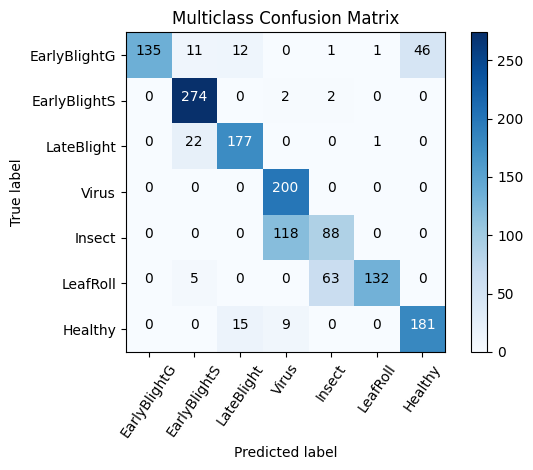

In [17]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Virus' , 'Insect','LeafRoll', 'Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [19]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight','Virus' , 'Insect','LeafRoll','Healthy' ]
print(classification_report(y_test, Y_pred, target_names=target_names))

47/47 [==============================] - 8s 167ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       1.00      0.66      0.79       206
EarlyBlight Serious       0.88      0.99      0.93       278
         LateBlight       0.87      0.89      0.88       200
              Virus       0.61      1.00      0.76       200
             Insect       0.57      0.43      0.49       206
           LeafRoll       0.99      0.66      0.79       200
            Healthy       0.80      0.88      0.84       205

           accuracy                           0.79      1495
          macro avg       0.82      0.79      0.78      1495
       weighted avg       0.82      0.79      0.79      1495



In [20]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("VGG16")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

47/47 [==============================] - 8s 170ms/step
VGG16
Accuracy: 0.7939799331103679
F1 Score: 0.7997509813003124
precision: 0.8429247245245532
recall: 0.7939799331103679
MSE: 1.6020066889632107
MAE: 0.43010033444816054


In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=6)
auc=metrics.auc(fpr, tpr)
auc

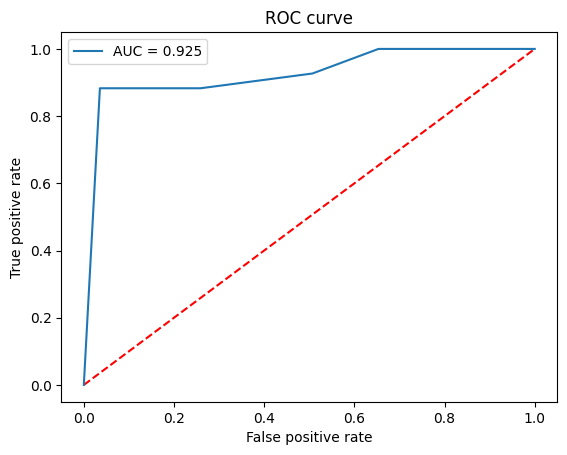

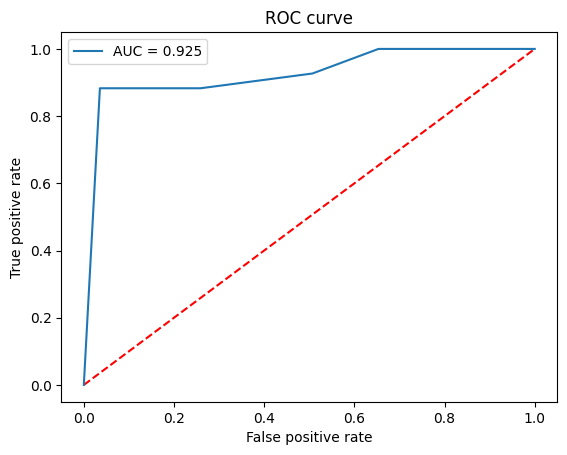

In [23]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
